## Data Hackfest May 2024 ##
Just to take notes, brainstorm, and work.

#### Toolbox

In [1]:
import pandas as pd
import numpy as np
import umap
import umap.plot
import os
import re

import pydotplus
import scipy.optimize as so
import sklearn as sk
import sklearn.linear_model as skl
import seaborn as sns
import sklearn.preprocessing as prep
import sklearn.metrics as metrics
import sklearn.feature_extraction.text as sktext
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as Rectangle
import uncertainty_toolbox as uct
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display, Image
%matplotlib inline

# %pip install uncertainty-toolbox
# %pip install yellowbrick
from itertools import product
from matplotlib.patches import Patch
from scipy.optimize import minimize
from scipy.sparse import csr_matrix
from scipy.special import gammaln
from scipy.stats import t
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_blobs, fetch_openml
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegressionCV, LinearRegression, LogisticRegression, LassoCV, lasso_path, SGDClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import auc, silhouette_score, r2_score, roc_curve, roc_auc_score, make_scorer, mean_squared_error, balanced_accuracy_score, accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, OneHotEncoder
from sklearn.tree import export_graphviz
from yellowbrick.cluster import SilhouetteVisualizer
from xgboost import XGBClassifier


seed = 1151 # work with this seed throughout your work
np.random.seed(seed)

c:\Users\jane8\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Analysis

This visualization program would be designed to cater to insurance companies. For sake of time, we assume the data is well-prepared and collected in an unbiased manner. Any rows with no values for fraud were removed for sake of time and simplicity of argumentation for the purpose of this project, as automating truly adequate and appropriate data cleaning and EDA is a whole project in itself.

In [3]:
df = pd.read_csv("auto_data.csv")
df.describe()
df.info()   # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11553 entries, 0 to 11552
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PolicyNumber     11553 non-null  int64  
 1   PolicyType       11553 non-null  object 
 2   Sex              11553 non-null  object 
 3   Age              11553 non-null  int64  
 4   MaritalStatus    11553 non-null  object 
 5   DriverRating     11553 non-null  int64  
 6   PastClaims       11553 non-null  object 
 7   Deductible       11553 non-null  int64  
 8   AddressChange    11553 non-null  object 
 9   VehicleCategory  11553 non-null  object 
 10  Make             11553 non-null  object 
 11  VehicleAge       11553 non-null  object 
 12  VehiclePrice     11553 non-null  object 
 13  AgentType        11553 non-null  object 
 14  RepNumber        11553 non-null  int64  
 15  Year             11553 non-null  int64  
 16  Month            11553 non-null  object 
 17  Week        

In [4]:
def fraudOnly(dataframe: pd.core.frame.DataFrame, colName: str, yesOrNo: int):
    newdf = dataframe[dataframe[colName] == yesOrNo]
    newdf.to_csv('fraud_only.csv', index=False)
    
fraudOnly(df, "Fraud", 1)

In [5]:
categorical_columns_object = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns (object type):")
print(categorical_columns_object)

Categorical columns (object type):
['PolicyType', 'Sex', 'MaritalStatus', 'PastClaims', 'AddressChange', 'VehicleCategory', 'Make', 'VehicleAge', 'VehiclePrice', 'AgentType', 'Month', 'Day', 'CarsInvolved', 'CollisionArea', 'Fault', 'InforceAccident', 'WitnessPresent', 'PoliceReport', 'MonthClaimed', 'DayClaimed', 'InforceClaim']


In [7]:
categoricals = ["PolicyType", "Sex", "MaritalStatus", "PastClaims", 
                "AddressChange", "VehicleCategory", "Make", "VehicleAge",
                "VehiclePrice", "AgentType", "Month", "Day", "CarsInvolved",
                "CollisionArea", "Fault", "InforceAccident", "WitnessPresent",
                "PoliceReport", "MonthClaimed", "DayClaimed", "InforceClaim"]
df_encoded = pd.get_dummies(df, columns=categoricals)
df_encoded.info()
df_encoded
df_encoded.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11553 entries, 0 to 11552
Columns: 125 entries, PolicyNumber to InforceClaim_>30
dtypes: float64(1), int64(9), uint8(115)
memory usage: 2.1 MB


Index(['PolicyNumber', 'Age', 'DriverRating', 'Deductible', 'RepNumber',
       'Year', 'Week', 'WeekClaimed', 'Claim', 'Fraud',
       ...
       'DayClaimed_Friday', 'DayClaimed_Monday', 'DayClaimed_Saturday',
       'DayClaimed_Sunday', 'DayClaimed_Thursday', 'DayClaimed_Tuesday',
       'DayClaimed_Wednesday', 'InforceClaim_15 to 30', 'InforceClaim_8 to 15',
       'InforceClaim_>30'],
      dtype='object', length=125)

In [10]:
def predict_most_influential_feature(data=df, targetName='Fraud'):

    # encode any categorical variables
    categorical_columns_object = df.select_dtypes(include=['object']).columns.tolist()  # list of column names
    df_encoded = pd.get_dummies(df, columns=categorical_columns_object)

    # set matrix of features and target
    features = df_encoded.drop(columns=[targetName], axis=1)
    target = df_encoded[targetName]

    # standardize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_encoded[features.columns])    

    # conduct pca
    pca = PCA(n_components=2, random_state=seed)
    X_pca = pca.fit_transform(scaled_features)
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features.columns)

    # state the most influential features for the 2 principal components
    most_influential_features_pc1 = loadings['PC1'].abs().nlargest(3).index
    most_influential_features_pc2 = loadings['PC2'].abs().nlargest(3).index
    print(f"Most influential features on PC1: {most_influential_features_pc1}")
    print(f"Most influential features on PC2: {most_influential_features_pc2}")
    
    return

predict_most_influential_feature()

Most influential features on PC1: Index(['VehicleCategory_Sedan', 'VehicleCategory_Sport',
       'PolicyType_Liability'],
      dtype='object')
Most influential features on PC2: Index(['CarsInvolved_2', 'AddressChange_0', 'AddressChange_4 to 8'], dtype='object')


Explained Variance Ratio: [0.03238373 0.027867  ]


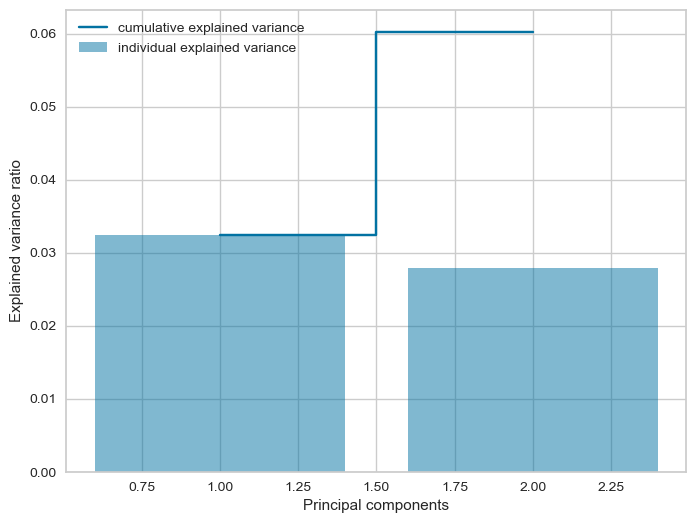

                            PC1       PC2
PolicyNumber           0.006374 -0.002747
Age                    0.050301 -0.043015
DriverRating           0.007735  0.006467
Deductible            -0.003180  0.027786
RepNumber             -0.003227 -0.003313
...                         ...       ...
DayClaimed_Tuesday     0.006337 -0.000857
DayClaimed_Wednesday   0.001911  0.002361
InforceClaim_15 to 30  0.080064  0.032250
InforceClaim_8 to 15   0.044341  0.006954
InforceClaim_>30      -0.091583 -0.031803

[124 rows x 2 columns]
Most influential feature on PC1: Index(['VehicleCategory_Sedan', 'VehicleCategory_Sport',
       'PolicyType_Liability'],
      dtype='object')
Most influential feature on PC2: Index(['CarsInvolved_2', 'AddressChange_0', 'AddressChange_4 to 8'], dtype='object')


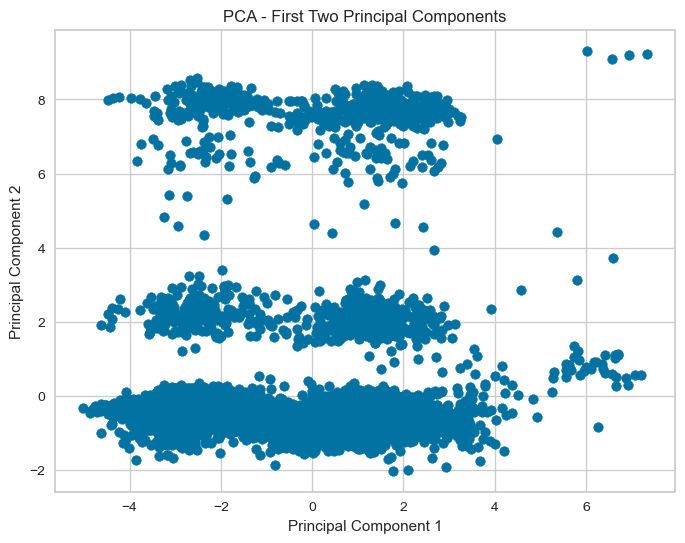

In [ ]:
features = df_encoded.drop(columns=['Fraud'], axis=1)
target = df_encoded['Fraud']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_encoded[features.columns])

# Create a PCA object
pca = PCA(n_components=2, random_state=seed)

# Fit the PCA model to the data
X_pca = pca.fit_transform(scaled_features)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Explained variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Plot the explained variance
plt.figure(figsize=(8,6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

# Get the loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features.columns)
print(loadings)

# Identify the most influential feature for the first principal component
most_influential_features_pc1 = loadings['PC1'].abs().nlargest(3).index
most_influential_features_pc2 = loadings['PC2'].abs().nlargest(3).index
print(f"Most influential feature on PC1: {most_influential_features_pc1}")
print(f"Most influential feature on PC2: {most_influential_features_pc2}")


# Visualize the first two principal components
plt.figure(figsize=(8,6))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components')
plt.show()


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, target, test_size=0.2, random_state=42)

In [ ]:
# this is what would happen if we just selected on the raw features (after encoding)
from sklearn.feature_selection import SelectKBest, chi2

# Use SelectKBest with chi-squared test
selector = SelectKBest(score_func=chi2, k='all')
selector.fit(features, target)

# Get the scores
scores = selector.scores_

# Create a DataFrame to display the scores
feature_scores = pd.DataFrame({'Feature': features.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

print(feature_scores)

                        Feature          Score
8                         Claim  154313.921867
0                  PolicyNumber   17873.275656
11         PolicyType_Liability     182.502909
92            Fault_Third Party     144.583391
28        VehicleCategory_Sport     140.223657
..                          ...            ...
59  VehiclePrice_40000 to 59000       0.006916
98            WitnessPresent_No       0.006445
5                          Year       0.003159
45                     Make_Ram       0.000268
55                 VehicleAge_7       0.000012

[124 rows x 2 columns]


In [ ]:
rf_model = RandomForestClassifier(random_state=seed)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_rf = pd.DataFrame({'Feature': pca_df.columns, 'Importance': importances})
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)

print(feature_importance_rf)


  Feature  Importance
0     PC1    0.517764
1     PC2    0.482236


In [ ]:
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.938987451319775
Confusion Matrix:
[[2168    7]
 [ 134    2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2175
           1       0.22      0.01      0.03       136

    accuracy                           0.94      2311
   macro avg       0.58      0.51      0.50      2311
weighted avg       0.90      0.94      0.91      2311



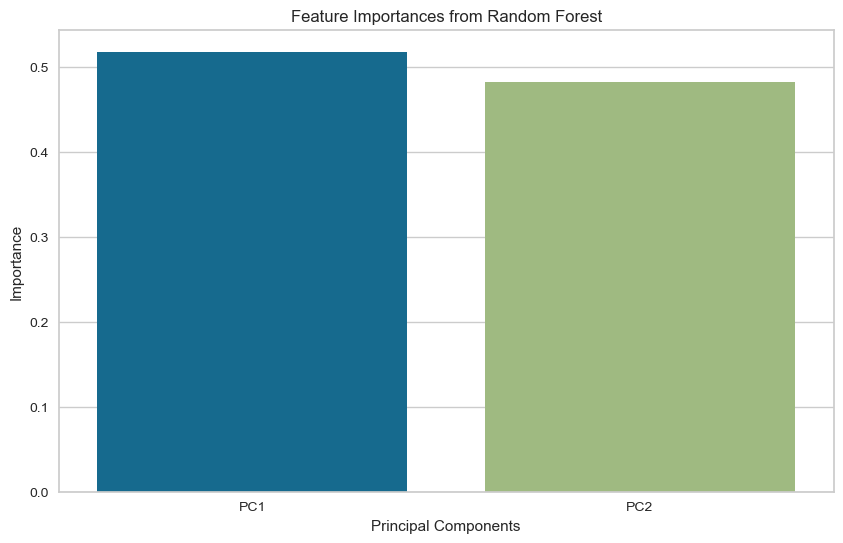

In [ ]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=['PC1', 'PC2'], y=importances)
plt.xlabel('Principal Components')
plt.ylabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.show()

---
$$fine$$

#### Toolbox

In [ ]:
import pandas as pd
import numpy as np
import umap
import umap.plot
import os
import re

import pydotplus
import scipy.optimize as so
import sklearn as sk
import sklearn.linear_model as skl
import seaborn as sns
import sklearn.preprocessing as prep
import sklearn.metrics as metrics
import sklearn.feature_extraction.text as sktext
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as Rectangle
import uncertainty_toolbox as uct
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display, Image
%matplotlib inline

# %pip install uncertainty-toolbox
# %pip install yellowbrick
from itertools import product
from matplotlib.patches import Patch
from scipy.optimize import minimize
from scipy.sparse import csr_matrix
from scipy.special import gammaln
from scipy.stats import t
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_blobs, fetch_openml
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegressionCV, LinearRegression, LogisticRegression, LassoCV, lasso_path, SGDClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import auc, silhouette_score, r2_score, roc_curve, roc_auc_score, make_scorer, mean_squared_error, balanced_accuracy_score, accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, OneHotEncoder
from sklearn.tree import export_graphviz
from yellowbrick.cluster import SilhouetteVisualizer
from xgboost import XGBClassifier


seed = 1151 # work with this seed throughout your work
np.random.seed(seed)

#### Analysis

This visualization program would be designed to cater to insurance companies. For sake of time, we assume the data is well-prepared and collected in an unbiased manner. Any rows with no values for fraud were removed for sake of time and simplicity of argumentation for the purpose of this project, as automating truly adequate and appropriate data cleaning and EDA is a whole project in itself.

In [ ]:
df = pd.read_csv("auto_data.csv")
df.describe()
df.info()   # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11553 entries, 0 to 11552
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PolicyNumber     11553 non-null  int64  
 1   PolicyType       11553 non-null  object 
 2   Sex              11553 non-null  object 
 3   Age              11553 non-null  int64  
 4   MaritalStatus    11553 non-null  object 
 5   DriverRating     11553 non-null  int64  
 6   PastClaims       11553 non-null  object 
 7   Deductible       11553 non-null  int64  
 8   AddressChange    11553 non-null  object 
 9   VehicleCategory  11553 non-null  object 
 10  Make             11553 non-null  object 
 11  VehicleAge       11553 non-null  object 
 12  VehiclePrice     11553 non-null  object 
 13  AgentType        11553 non-null  object 
 14  RepNumber        11553 non-null  int64  
 15  Year             11553 non-null  int64  
 16  Month            11553 non-null  object 
 17  Week        

In [ ]:
def fraudOnly(dataframe: pd.core.frame.DataFrame, colName: str, yesOrNo: int):
    newdf = dataframe[dataframe[colName] == yesOrNo]
    newdf.to_csv('fraud_only.csv', index=False)
    
fraudOnly(df, "Fraud", 1)

In [ ]:
categoricals = ["PolicyType", "Sex", "MaritalStatus", "PastClaims", 
                "AddressChange", "VehicleCategory", "Make", "VehicleAge",
                "VehiclePrice", "AgentType", "Month", "Day", "CarsInvolved",
                "CollisionArea", "Fault", "InforceAccident", "WitnessPresent",
                "PoliceReport", "MonthClaimed", "DayClaimed", "InforceClaim"]
df_encoded = pd.get_dummies(df, columns=categoricals)
df_encoded.info()
df_encoded
df_encoded.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11553 entries, 0 to 11552
Columns: 125 entries, PolicyNumber to InforceClaim_>30
dtypes: float64(1), int64(9), uint8(115)
memory usage: 2.1 MB


Index(['PolicyNumber', 'Age', 'DriverRating', 'Deductible', 'RepNumber',
       'Year', 'Week', 'WeekClaimed', 'Claim', 'Fraud',
       ...
       'DayClaimed_Friday', 'DayClaimed_Monday', 'DayClaimed_Saturday',
       'DayClaimed_Sunday', 'DayClaimed_Thursday', 'DayClaimed_Tuesday',
       'DayClaimed_Wednesday', 'InforceClaim_15 to 30', 'InforceClaim_8 to 15',
       'InforceClaim_>30'],
      dtype='object', length=125)

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_encoded)
labels = kmeans.predict(df_encoded)

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
pca = PCA(n_components=2)
model = pca.fit_transform(df_encoded)
pca_df = pd.DataFrame(data=model, columns=['PC1', 'PC2'])

ValueError: Shape of passed values is (11553, 125), indices imply (11553, 2)

In [ ]:
# PCA_model = PCA(
#     n_components=None,     # Number of components to keep. If None, all components are kept.
#     copy=True,             # Whether to copy the input data or perform in-place normalization.
#     whiten=False,          # Whether to whiten the components to make their variances uniform.
#     svd_solver='auto',     # SVD solver to use. Options are 'auto', 'full', 'arpack', 'randomized'.
#     tol=0.0,               # Tolerance for singular values computed by SVD solver.
#     iterated_power='auto', # Number of iterations for the power method used by the 'randomized' SVD solver.
#     random_state=None      # Determines random number generation for randomized SVD solver.
# )

# 2 component PCA (SEE ASN8)
pca = PCA()
model_pca = pca.fit_transform(data)
pca_df = pd.DataFrame(data=model_pca, columns=['PC1', 'PC2'])

# plot PC1 vs PC2
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha = 0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

pca = PCA()   # reminder that we use pca to reduce dimensionality to 2d, sometimes 3
X_pca = pca.fit_transform(df_encoded)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustered Data (PCA)')
plt.colorbar(label='Cluster')
plt.show()